In [2]:
from copy import deepcopy
import pdb
import warnings
from imp import reload
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from grid_explore import GridSearchExplorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator

from plot_learning_curve import plot_learning_curve

%matplotlib inline

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])


# # using built-in 'neg_log_loss' scoring param used for simplicity
# # source code show exact same make_scorer call, kept for reference
# log_loss_scorer = make_scorer(log_loss, greater_is_better=False,
#                               needs_proba=True)

SCORING = 'neg_log_loss'

In [2]:
def read_rental_interest_json(fp):
    """Reads Two Sigma Connect: Rental Listing Inquiries json."""
    
    df = (pd.read_json(TRAIN_FP)
          .set_index('listing_id')
         )
    df.created = pd.to_datetime(df.created)
    
    return df

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

BASIC_FEATURES = ['bathrooms', 'bedrooms', 'price']
TARGET =  ['interest_level']


df = read_rental_interest_json(TRAIN_FP)
df_ = df[BASIC_FEATURES+TARGET]

y = LabelEncoder().fit_transform(df_.interest_level)
X = df_.drop('interest_level', axis=1)

X_train, X_test, y_train, y_test = (
    train_test_split(
        X, y, test_size=.5, stratify=df_.interest_level)
    )

min: 0 (n=3218)
med: 5.0
max: 39


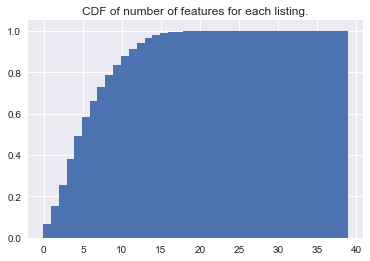

In [23]:
n_feats = df.features.map(lambda x: len(x))
plt.hist(n_feats, cumulative=True, normed=True, bins=300, align='left')
plt.title('CDF of number of features for each listing.')
print('min: {} (n={})\nmed: {}\nmax: {}'.format(
    n_feats.min(), (n_feats==0).sum(),
    n_feats.median(), n_feats.max()))
# n_feats.value_counts(normalize=True).sort_index()

In [24]:
def contains_punc(criteria, feats_list, regex=False):
    """Checks for punctuation in feature list.
    
    Can be used to determine the nature of difference
    puncuations.
    
    Parameters
    ----------
    criteria : list of str or raw/str
        list of punctuation marks, or regex to match punctuation
    feats_list : list
    
    Returns
    -------
    has_punc : bool
    """
    
    if regex:
        reg = re.compile(criteria)
    
    # return True 
    for feat in feats_list:
        if regex:
            if reg.match(feat):
                return True
        else:
            for s in criteria:
                if s in feat:
                    return True
    
    # if no punctuation found in list of features
    return False

In [25]:
from collections import Counter
import re

def extract_clean_feats(feats):
    """Extract and normalize each feature in list."""
    
#     cleaner = lambda x: re.sub(r'[ ]*[^\w ][ ]*', ' ', x)
    cleaner = lambda x: x.upper().strip().replace('-', '')
#     cleaner = lambda x: x
    cleaned = (cleaner(feat) for feat in feats)
    
    return cleaned


def count_feats(feat_col):
    """Extracts features from list and returns counter."""
    
    cnt = Counter()
    for _, feats in feat_col.iteritems():
        feats = set(extract_clean_feats(feats))  # remove dupes too
        cnt.update(feats)
        
    return cnt

feat_cnts = count_feats(df.features)
feat_cnts.most_common(5)

[('ELEVATOR', 26272),
 ('HARDWOOD FLOORS', 23558),
 ('CATS ALLOWED', 23540),
 ('DOGS ALLOWED', 22035),
 ('DOORMAN', 20966)]

In [26]:
df[df.features.map(lambda x: contains_punc(['*'], x))].head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address
listing_id,,,,,,,,,,,,,,
6856770,1.0,1,56c3771d9e2a441395c646effabe40bb,2016-04-11 17:07:36,"LOOK NO FURTHER\r\rWell maintained, pre-war bl...",midtown west,[** CLASSY CLINTON HOME * MASSIVE 1BR * GOURME...,low,40.7592,-73.9903,699c325b818541f314b691b76f3238d7,[https://photos.renthop.com/2/6856770_03902dfe...,2150,329 W 44th St
6856878,1.0,2,bee9bad998da3743d98f7f11ce8f749d,2016-04-11 19:42:52,LOOK NO FURTHER!!\r\rNO BROKER FEE!!\r\rMassiv...,williamsburg - NO FEE,"[Common Outdoor Space, Private Outdoor Space, ...",low,40.7165,-73.9505,699c325b818541f314b691b76f3238d7,[https://photos.renthop.com/2/6856878_d4ff644d...,3500,"241 Meeker Ave,"


In [27]:
def binarize_from_list_vals(col):
    """Transforms Series of lists to dummy variables."""
    
    SEP = '~~//'  # any value that won't be in strings in list

    cleaned = col.apply(lambda x: extract_clean_feats(x))
    dummies = cleaned.str.join(sep=SEP).str.get_dummies(sep=SEP)

    return dummies

feats_df = binarize_from_list_vals(df.features)
feats_df.head(2)

,!!!!LOW FEE!!!!,$1000. MOVEIN VISA GIFTCARD WILL BE HANDED TO NEW TENANTS UPON RENTAL LEASE SIGNING,$1500. MOVEIN VISA GIFTCARD WILL BE HANDED TO NEW TENANTS UPON RENTAL LEASE SIGNING,$250 APPLICATION FEE WITH BACKGROUND AND CREDIT CHECK. BOARD INTERVIEW AND APPROVAL.,$250 SECURITY DEPOSIT,$500 SECURITY DEPOSIT,$600 GIFT CARD FOR MOVEINS PRIOR TO JUNE 19,& ATM MACHINE ONSITE,* MARVELOUS MIDTOWN GEM * SPACIOUS SUNDRENCHED STUDIO * STUNNING PREWAR DETAILS * CATS OK **,** ALL BRAND NEW NO FEE! * EXPANSIVE 2BR MCMANSION * PRIVATE TERRACE * COOK'S SS KITCHEN * ELEV/LNDRY BLDG * 3 BLKS TO L TRAIN **,...,XXL WINDOWS,XXLARGE STUDIO,YARD,YOGA / DANCE STUDIO,YOGA AN PILATES CLASS,YOGA AND SPIN STUDIOS,YOGA CLASSES,YOGA ROOM,YOGA STUDIO,• ONSITE LIFESTYLE CONCIERGE BY LUXURY ATTACHÉ •24/7 DOORMAN • STATE OF THE ART CARDIOVASCULAR AND WEIGHT TRAINING EQUIPMENT • 24HOUR VALET PARKING GARAGE • VALET SERVICES INCLUDING DRY CLEANING
listing_id,,,,,,,,,,,,,,,,,,,,,
7211212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7150865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from sklearn.decomposition import PCA
pca = PCA()

feats_train = feats_df.loc[X_train.index]
feats_test = feats_df.loc[X_test.index]

pca.fit(feats_train)
list(pca.explained_variance_ratio_[:4])

[0.24770773350968076,
 0.14268873655740147,
 0.084171901765233328,
 0.049268961596363917]

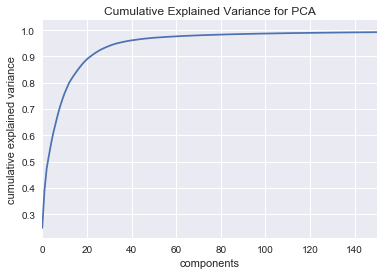

In [29]:
plt.title('Cumulative Explained Variance for PCA')

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlim(0, 150)
plt.xlabel('components')
plt.ylabel('cumulative explained variance');

In [30]:
N_COMPONENTS = 1000
# N_COMPONENTS = len(pca.components_)

cols = ['FeatComp{}'.format(i+1) for i in range(0, N_COMPONENTS)]

reduced_train = pd.DataFrame(
    pca.transform(feats_train)[:, :N_COMPONENTS], 
    columns=cols, index=feats_train.index
)
reduced_test  = pd.DataFrame(
    pca.transform(feats_test)[:, :N_COMPONENTS], 
    columns=cols, index=feats_test.index
)

# allows rejoining reduced data after reprocessing
X_train = X_train.loc[:, ~X_train.columns.isin(cols)]
X_test  = X_test.loc[:, ~X_test.columns.isin(cols)]

X_train = X_train.join(reduced_train)
X_test  = X_test.join(reduced_test)

In [31]:
steps = [('reducer', PCA()),
         ('clf', GradientBoostingClassifier(min_samples_split=50))]
pipe = Pipeline(steps=steps)

params = {
#     'reducer': [PCA()],
    'reducer__n_components': [50],
#     'clf__min_samples_split': [120],
#     'clf__learning_rate': np.linspace(0.1, 0.4, 5),
#     'clf__learning_rate': [0.05, 0.1, 0.15],
#     'clf_max_depth': range(3, 7, 1),
#     'pca__n_components': [10, 20, 25],
#     'pca__n_components': [10, 40],
#     'clf__min_samples_split': [120, 180],
              }

grid = GridSearchCV(pipe, params, scoring=SCORING, n_jobs=4)

# start = time.time()
grid.fit(feats_train.iloc[:100], y_train[:100])
# end = time.time()

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('reducer', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_featur...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'reducer__n_components': [50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='neg_log_loss',
       verbose=0)

In [21]:
df.shape

(49352, 14)